### Imports and class definitions

In [1]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr

from helpers import *
import cca_helpers

In [3]:
def filter_data(spike_bins, trial_inf, neuron_inf, trial_types, areas):
    if not isinstance(trial_inf, trial_info):
        raise ValueError(f"Expected trial inf to be of type __main__.trial_info but got {type(trial_inf)} instead")
    
    if not isinstance(neuron_inf, neuron_info):
        raise ValueError(f"Expected trial inf to be of type __main__.neuron_info but got {type(trial_inf)} instead")
        
    if not isinstance(areas, list):
        raise ValueError(f"areas to be of type list but got {type(areas)} instead")
        
    if not isinstance(trial_types, list):
        raise ValueError(f"trial_types to be of type list but got {type(areas)} instead")

        
    f_data = {}
    for trial_type in trial_types:
        if trial_type not in trial_inf.trial_types:
            raise NameError(f"Trial type can only be one of the following: {trial_inf.trial_types}")
        
        else:
            f_data[trial_type] = {}
            trial_type_idx = trial_inf.trial_index[trial_type]
            for area in areas:
                if area not in neuron_inf.areas:
                    print(area)
                    raise NameError(f"Area can only be one of the following: {neuron_inf.areas}")
                    
                else:
                    area_idx = neuron_inf.area_idx[area]
                    
                    
                    f_data[trial_type][area] = spike_bins[area_idx][:,trial_type_idx,:]
                    
    return f_data
                
                
    
    

### Loading data

In [3]:
trial_inf = trial_info(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_trial_data.csv")
neuron_inf = neuron_info(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_cluster_spike_times_2.csv")
spike_array = np.load(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_spikes_dense.npy")

In [5]:
ah_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Auditory Hit"], ["tjM1", "DLS"])["Auditory Hit"]
print(ah_spikes["DLS"].shape)
cr_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Correct Rejection"], ["tjM1", "DLS"])["Correct Rejection"]
print(cr_spikes["DLS"].shape)

(135, 83, 401)
(135, 211, 401)


In [15]:
ahtjm1 = ah_spikes["tjM1"][:,:,95:]
ahtjm1 = convolve_1d(ahtjm1, axis=2)[]
re_ahtjm1 = ahtjm1.reshape(166,-1)
mc_ahtjm1 = re_ahtjm1 - re_ahtjm1.mean(axis=1)[:,np.newaxis]

ahdls = ah_spikes["DLS"][:,:,100:]
ahdls = convolve_1d(ahdls, axis=2)
re_ahdls = ahdls.reshape(135,-1)
mc_ahdls = re_ahdls - re_ahdls.mean(axis=1)[:,np.newaxis]


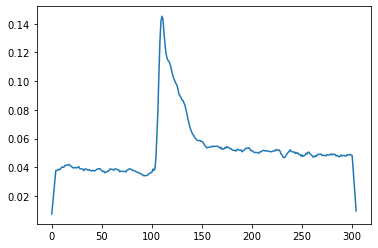

In [16]:
fig, ax = plt.subplots()
ax.plot(ahtjm1.mean(axis=(0,1)))


In [137]:
print(mc_ahtjm1.shape)
print(mc_ahdls.shape)

(166, 24983)
(135, 24983)


### Align using CCA

In [9]:
n_pcs=80
basis_ahtjm1, basis_ahdls, ah_cc = cca_helpers.align(mc_ahtjm1.T, mc_ahdls.T, m=n_pcs)
ah_cc = np.asarray(ah_cc)
print(basis_ahtjm1.shape, basis_ahdls.shape, ah_cc.shape)

(166, 80) (135, 80) (80,)


Text(0, 0.5, 'Canonical correlation')

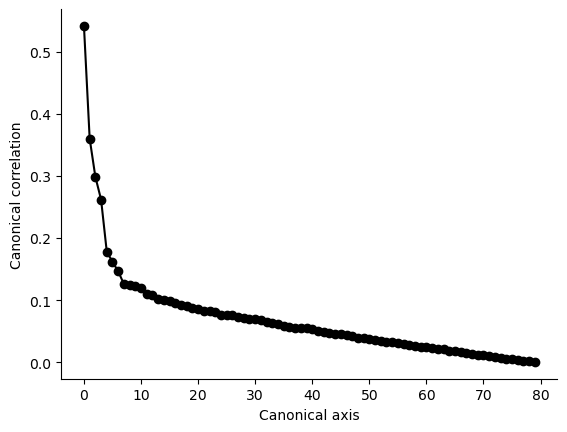

In [10]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(ah_cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')

### Here we try the same regions but during the correct rejection trials

In [11]:
crtjm1 = cr_spikes["tjM1"][:,:,100:]
re_crtjm1 = crtjm1.reshape(166,-1)
mc_crtjm1 = re_crtjm1 - re_crtjm1.mean(axis=1)[:,np.newaxis]

crdls = cr_spikes["DLS"][:,:,100:]
re_crdls = crdls.reshape(135,-1)
mc_crdls = re_crdls - re_crdls.mean(axis=1)[:,np.newaxis]

In [143]:
print(mc_crtjm1.shape)
print(mc_crdls.shape)

(166, 63511)
(135, 63511)


In [168]:
n_pcs=80
basis_crtjm1, basis_crdls, cr_cc = cca_helpers.align(mc_crtjm1.T, mc_crdls.T, m=n_pcs)
cr_cc = np.asarray(cr_cc)
print(basis_crtjm1.shape, basis_crdls.shape, cr_cc.shape)

(166, 80) (135, 80) (80,)


Text(0, 0.5, 'Canonical correlation')

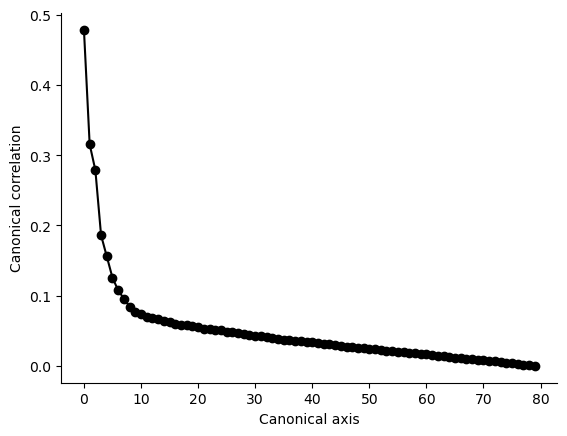

In [169]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cr_cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')

### Here we try the same regions but during the whisker hit trials

In [166]:
wh_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Whisker Hit"], ["tjM1", "DLS"])["Whisker Hit"]
print(cr_spikes["DLS"].shape)

(135, 211, 401)


(166, 12642)
(135, 12642)
(166, 80) (135, 80) (80,)


Text(0, 0.5, 'Canonical correlation')

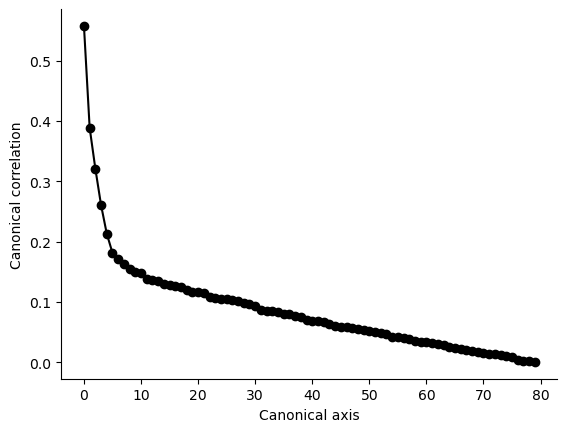

In [170]:
whtjm1 = wh_spikes["tjM1"][:,:,100:]
re_whtjm1 = whtjm1.reshape(166,-1)
mc_whtjm1 = re_whtjm1 - re_whtjm1.mean(axis=1)[:,np.newaxis]

whdls = wh_spikes["DLS"][:,:,100:]
re_whdls = whdls.reshape(135,-1)
mc_whdls = re_whdls - re_whdls.mean(axis=1)[:,np.newaxis]

print(mc_whtjm1.shape)
print(mc_whdls.shape)

n_pcs=80
basis_whtjm1, basis_whdls, wh_cc = cca_helpers.align(mc_whtjm1.T, mc_whdls.T, m=n_pcs)
wh_cc = np.asarray(wh_cc)
print(basis_whtjm1.shape, basis_whdls.shape, wh_cc.shape)

fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(wh_cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')

### Other two trial types

In [179]:
wm_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Whisker Miss"], ["tjM1", "DLS"])["Whisker Miss"]
print(wm_spikes["DLS"].shape)

fa_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["False Alarm"], ["tjM1", "DLS"])["False Alarm"]
print(fa_spikes["DLS"].shape)

(135, 140, 401)
(135, 36, 401)


In [180]:
wmtjm1 = wm_spikes["tjM1"][:,:,100:]
re_wmtjm1 = wmtjm1.reshape(166,-1)
mc_wmtjm1 = re_wmtjm1 - re_wmtjm1.mean(axis=1)[:,np.newaxis]

wmdls = wm_spikes["DLS"][:,:,100:]
re_wmdls = wmdls.reshape(135,-1)
mc_wmdls = re_wmdls - re_wmdls.mean(axis=1)[:,np.newaxis]

print(mc_wmtjm1.shape)
print(mc_wmdls.shape)

n_pcs=80
basis_wmtjm1, basis_wmdls, wm_cc = cca_helpers.align(mc_wmtjm1.T, mc_wmdls.T, m=n_pcs)
wm_cc = np.asarray(wm_cc)
print(basis_wmtjm1.shape, basis_wmdls.shape, wm_cc.shape)

(166, 42140)
(135, 42140)
(166, 80) (135, 80) (80,)


In [183]:
fatjm1 = fa_spikes["tjM1"][:,:,100:]
re_fatjm1 = fatjm1.reshape(166,-1)
mc_fatjm1 = re_fatjm1 - re_fatjm1.mean(axis=1)[:,np.newaxis]

fadls = fa_spikes["DLS"][:,:,100:]
re_fadls = fadls.reshape(135,-1)
mc_fadls = re_fadls - re_fadls.mean(axis=1)[:,np.newaxis]

print(mc_fatjm1.shape)
print(mc_fadls.shape)

n_pcs=80
basis_fatjm1, basis_fadls, fa_cc = cca_helpers.align(mc_fatjm1.T, mc_fadls.T, m=n_pcs)
fa_cc = np.asarray(fa_cc)
print(basis_fatjm1.shape, basis_fadls.shape,fa_cc.shape)

(166, 10836)
(135, 10836)
(166, 80) (135, 80) (80,)


### All trial types together

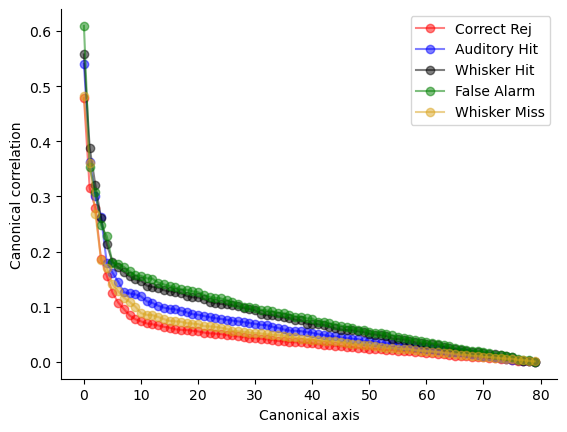

In [185]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cr_cc, marker='o', c='r', label = "Correct Rej", alpha = 0.5)
ax.plot(ah_cc, marker="o", c="b", label = "Auditory Hit", alpha = 0.5)
ax.plot(wh_cc, marker="o", c="k", label = "Whisker Hit", alpha = 0.5)
ax.plot(fa_cc, marker="o", c="g", label = "False Alarm", alpha = 0.5)
ax.plot(wm_cc, marker="o", c="goldenrod", label = "Whisker Miss", alpha = 0.5)
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')
plt.legend()

(166, 83, 301)
(24983, 80)
(83, 301, 80)
(135, 83, 301)
(24983, 80)


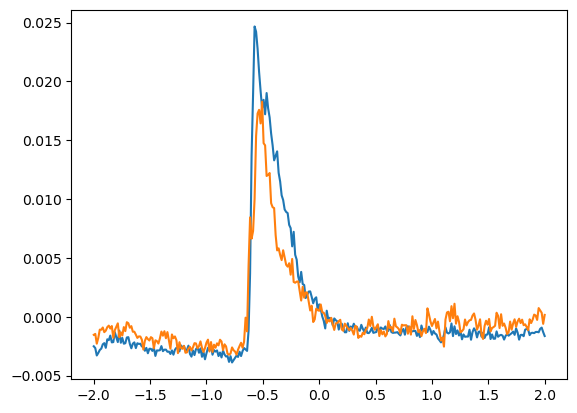

In [22]:
print(ahtjm1.shape)
proj_ahtjm1 = mc_ahtjm1.T @ basis_ahtjm1
print(proj_ahtjm1.shape)
re_proj_ahtjm1 = proj_ahtjm1.reshape(83,301,80)
print(re_proj_ahtjm1.shape)

print(ahdls.shape)
proj_ahdls = mc_ahdls.T @ basis_ahdls
print(proj_ahdls.shape)
re_proj_ahdls = proj_ahdls.reshape(83,301,80)

fig, ax = plt.subplots()
ax.plot(np.linspace(-2,2,301),re_proj_ahtjm1[:,:,0].mean(axis=0))
ax.plot(np.linspace(-2,2,301),re_proj_ahdls[:,:,0].mean(axis=0))

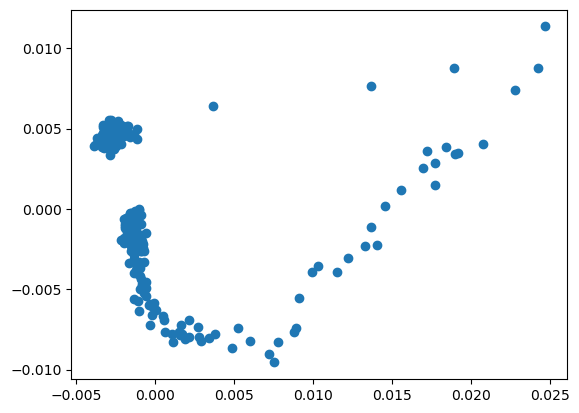

In [14]:
fig, ax = plt.subplots()
ax.scatter(re_proj_ahtjm1[:,:,0].mean(axis=0), re_proj_ahtjm1[:,:,1].mean(axis=0))

In [210]:
np.corrcoef(re_proj_ahtjm1[0,:,:].mean(axis=0), re_proj_ahdls[0,:,:].mean(axis=0))

array([[1.        , 0.45538744],
       [0.45538744, 1.        ]])

### Something else

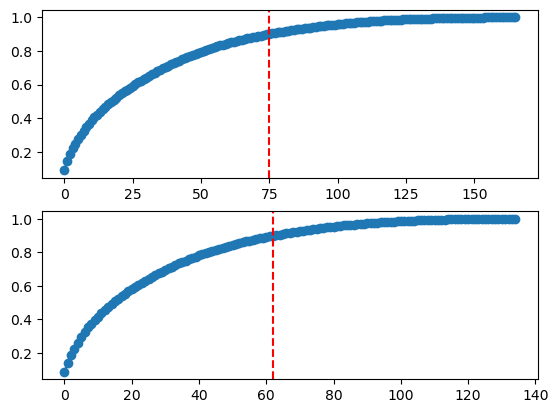

In [16]:
pca_tjm1 = PCA()
pca_tjm1.fit(mc_ahtjm1)

pca_dls = PCA()
pca_dls.fit(mc_ahdls)

fig, ax = plt.subplots(2,1)
ax[0].plot(np.cumsum(pca_tjm1.explained_variance_ratio_), marker="o")
ax[0].axvline(np.argmin(np.abs(np.cumsum(pca_tjm1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
ax[1].plot(np.cumsum(pca_dls.explained_variance_ratio_), marker="o")
ax[1].axvline(np.argmin(np.abs(np.cumsum(pca_dls.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

In [18]:
n_latents = 80
pca_ahtjm1 = PCA(n_components=n_latents) # TODO: cross/validate train and test
proj_ahtjm1 = pca_ahtjm1.fit_transform(mc_ahtjm1.T)

pca_ahdls = PCA(n_components=n_latents)
proj_ahdls = pca_ahdls.fit_transform(mc_ahdls.T)

In [21]:
re_pcaproj_ahtjm1 = proj_ahtjm1.reshape(-1,83, n_latents)
re_pcaproj_ahdls = proj_ahdls.reshape(-1,83, n_latents)
print(re_proj_ahtjm1.shape)

(301, 83, 80)


### Comparison between PCA and CCA

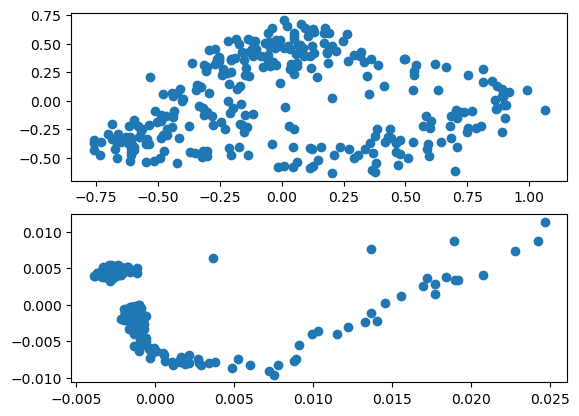

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].scatter(re_pcaproj_ahtjm1[:,:,0].mean(axis=1), re_pcaproj_ahtjm1[:,:,1].mean(axis=1))
ax[1].scatter(re_proj_ahtjm1[:,:,0].mean(axis=0), re_proj_ahtjm1[:,:,1].mean(axis=0))